In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
max_t = 75

np.random.seed(5)

In [3]:
def generate_dataset(num_trial, t=75, stim_win=[5,46]):
    arr = np.array([ 1, 2, 4, 8, 16])
    arr =  3.2 * 0.01 * np.concatenate([-arr[::-1], arr])
    
    u_bar = np.random.choice(arr, size=num_trial)
    
    u = np.zeros((t, num_trial))
    for i in range(num_trial):
        u[:,i] = np.random.normal(0, 0.03, size=t)
        u[stim_win[0]:stim_win[1],i] += u_bar[i]

    y = np.ones_like(u_bar,dtype='float')
    y[u_bar < 0] = -1
    #y = (u_bar > 0).astype('float')

    r_dict = {'u_bar':u_bar.astype(np.float32), 'y':y.astype(np.float32), 'u':u.astype(np.float32)}    
    return r_dict

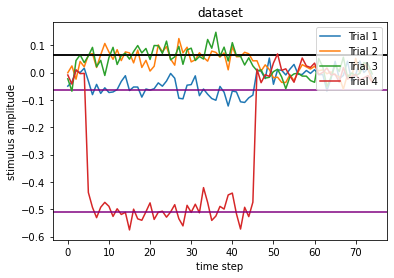

In [4]:
num_trial = 4
dataset = generate_dataset(num_trial)

u_bar = dataset['u_bar']
y = dataset['y']
u = dataset['u']

for i in range(num_trial):
    plt.plot(u[:,i], label=f"Trial {i+1}")
    if y[i]==1:
        c = 'black'
    else:
        c = 'purple'
    plt.axhline(y=u_bar[i], color=c, linestyle='-')

plt.xlabel('time step')
plt.ylabel('stimulus amplitude')

plt.plot()
plt.legend(loc ='upper right')
plt.title('dataset')
plt.show()

2.

In [5]:
class LowRankRNN(torch.nn.Module):
    def __init__(self, N, del_t, tau):
        super(LowRankRNN, self).__init__()
        self.m = torch.nn.Parameter(torch.normal(0, 0.05, (N, 1)))
        self.n = torch.nn.Parameter(torch.normal(0, 0.05, (1, N)))
        self.I = torch.nn.Parameter(torch.normal(0, 0.05, (1, N)))
        self.w = torch.nn.Parameter(torch.normal(0, 0.05, (N, 1)))

        # self.j = torch.nn.Parameter(torch.normal(0, 0.05, (N, N)))
        # self.j.requires_grad = True

        self.time_mul = del_t / tau

        self.N = N

    def forward(self, u, x): # u->(batch, 1), x->(batch, N) 

        j = torch.mm(self.m, self.n)
        j = torch.div(j, self.N)

        a = torch.tanh(x)
        a = torch.matmul(a, j) # -> (batch, N)

        # a = torch.tanh(x_t)
        # a = torch.matmul(self.j, a) # -> (N, batch)

        b = torch.mm(u, self.I) # -> (batch, N)

        c = torch.add(a, b)
        c = torch.sub(c, x)
        c = torch.mul(c, self.time_mul)

        xx = torch.add(x, c) # -> (batch, N)
        
        out = torch.mm(xx, self.w) #->(batch, 1)
        out  = torch.div(out, self.N)
        return out, xx

    def init_x(self, batch_size=16):
        return torch.normal(0, 0.05, (batch_size, self.N))

In [6]:
def input_to_tensor(u):
    s = u.reshape(u.shape[0], u.shape[1], 1)
    return torch.from_numpy(s)

In [7]:
def output_to_tensor(y):
    return torch.from_numpy(y.reshape(-1,1))   

In [8]:
def random_shuffle(dataset, batch_size):
    n_trial = dataset['y'].shape[0]

    perm = np.random.permutation(n_trial)
    
    num_batch = n_trial // batch_size

    in_list = []
    out_list = []

    for i in range(num_batch):
        idx = perm[i*batch_size:(i+1)*batch_size]

        us = dataset['u'][:,idx]
        ys = dataset['y'][idx].astype(np.float32)

        in_list.append(us.copy())
        out_list.append(ys.copy())

    return num_batch, in_list, out_list

In [9]:
def training(batch_size=32, t_step=max_t):
    # Low rank RNN params
    tau = 100e-3
    del_t = 20e-3
    N = 128
    n_trial = 2048

    # Autograd Params
    lr = 5e-3
    T=15
    rnn = LowRankRNN(N, del_t, tau)

    err_min = 5e-3

    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)

    dataset = generate_dataset(num_trial=n_trial, t=t_step)
    loss_log = []
    epoch = 0
    #for epoch in range(num_epochs):
    while True:
        epoch+=1

        num_batch, in_list, out_list = random_shuffle(dataset, batch_size)

        for i in range(num_batch):
        
            x_past = rnn.init_x(batch_size)
            in_tensor = input_to_tensor(in_list[i])
            out_tensor = output_to_tensor(out_list[i])
            

            outs = []
            loss_sum = 0
            for j in range(t_step):
                out, x_past = rnn(in_tensor[j,:,:], x_past)
                outs.append(out)

            optimizer.zero_grad()   

            for j in range(-T, 0):    
                loss = criterion(outs[j], out_tensor)  
                loss.backward(retain_graph=True)
                loss_sum  += loss.item()
            optimizer.step()
            
            loss_log.append(loss_sum/(T))

        if epoch % 10 == 0:
          print('loss: {}'.format(loss_log[-1]))
            
        if loss_log[-1]<err_min:
          print('loss: {}'.format(loss_log[-1]))
          print('training finished')
          break

    return [rnn.m.data.numpy(), rnn.n.data.numpy(), rnn.I.data.numpy(), rnn.w.data.numpy()], rnn

In [10]:
weights, model = training()

loss: 0.003214781063919266
training finished


In [11]:
dataset = generate_dataset(num_trial=1, t=max_t)
num_batch, in_list, out_list = random_shuffle(dataset, 1)
x_past = model.init_x(1)
outs = []
for i in range(max_t):
    in_tensor = torch.from_numpy(dataset['u'][i].reshape(1,1))
    out, x_past = model.forward(in_tensor, x_past)
    outs.append(out.detach().numpy())

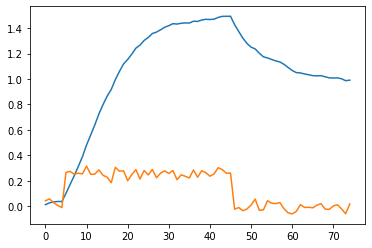

In [12]:
outs= np.array(outs).ravel()

plt.plot(outs)
plt.plot(dataset['u'])


plt.show()

3. 

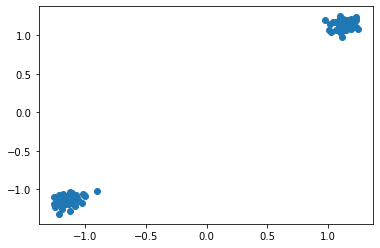

In [13]:
plt.scatter(weights[0], weights[1])
plt.show()

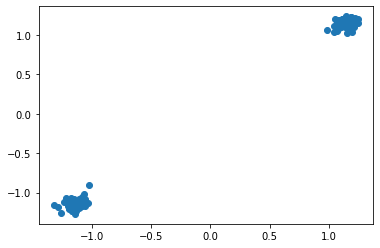

In [14]:
plt.scatter(weights[1], weights[2])
plt.show()

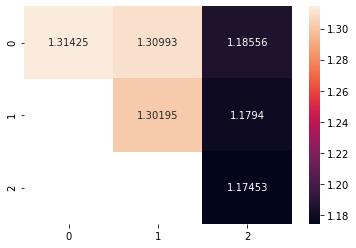

In [15]:
# nmIw = np.tanspose(weight, (1,0,2,3))
m= weights[0].ravel()
n= weights[1].ravel()
I= weights[2].ravel()
w= weights[3].ravel()

weights_data = np.array([I,n,m,w])

#covMatrix = np.cov(weights_data,bias=True)
covMatrix = np.cov(weights_data)
covSliced = covMatrix[:3,1:]
mask = np.zeros_like(covSliced)
# mask[1,0] = 1
# mask[2,0] = 1
mask[1:3, 0:2] =1 
mask[1,1] = 0
sns.heatmap(covSliced, mask=mask, annot=True, fmt='g')
plt.show()


<AxesSubplot:>

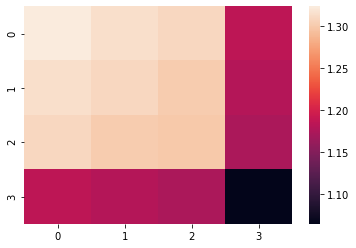

In [16]:
sns.heatmap(covMatrix)

5.

In [17]:
mean_weights = np.mean(weights_data, axis=1)
# print(mean_weights.shape)
#mean_weights = np.zeros(len(weights_data))

resampled_weights = np.random.multivariate_normal(mean_weights, covMatrix, 128)

In [18]:
resampled_rnn = LowRankRNN(N=128,tau = 100e-3, del_t = 20e-3)

In [19]:
resampled_rnn.state_dict()['m'][:] = torch.Tensor(resampled_weights[:,0].reshape(-1,1))
resampled_rnn.state_dict()['n'][:] = torch.Tensor(resampled_weights[:,1].reshape(1,-1))
resampled_rnn.state_dict()['I'][:] = torch.Tensor(resampled_weights[:,2].reshape(1,-1))
resampled_rnn.state_dict()['w'][:] = torch.Tensor(resampled_weights[:,3].reshape(-1,1))

In [20]:
dataset = generate_dataset(num_trial=1, t=max_t)
num_batch, in_list, out_list = random_shuffle(dataset, 1)
x_past = model.init_x(1)
outs = []
for i in range(max_t):
    in_tensor = torch.from_numpy(dataset['u'][i].reshape(1,1))
    out, x_past = model.forward(in_tensor, x_past)
    outs.append(out.detach().numpy())

In [21]:

x_past_resampled = resampled_rnn.init_x(1)
outs_resampled =[]
for i in range(max_t):
    in_tensor2 = torch.from_numpy(dataset['u'][i].reshape(1,1))

    out1, x_past_resampled = resampled_rnn.forward(in_tensor2, x_past_resampled)

    outs_resampled.append(out1.detach().numpy())


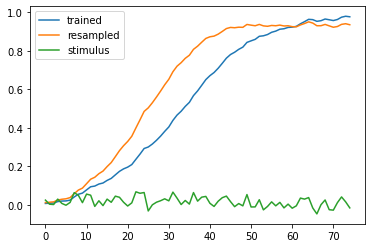

In [22]:
outs = np.array(outs).ravel()
outs_resampled = np.array(outs_resampled).ravel()

plt.plot(outs, label='trained')
plt.plot(outs_resampled, label='resampled')
plt.plot(dataset['u'], label='stimulus')

plt.legend()
plt.show()

In [23]:
resampled_cov = np.cov(resampled_weights.T)

<AxesSubplot:>

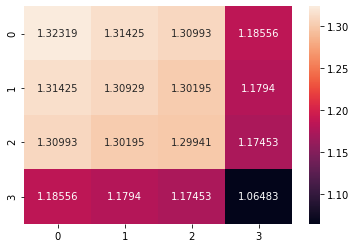

In [24]:
sns.heatmap(covMatrix, annot=True, fmt='g')

<AxesSubplot:>

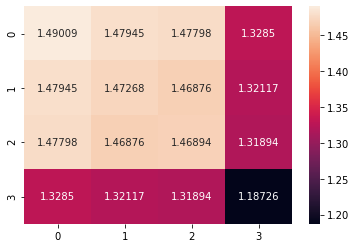

In [25]:

sns.heatmap(resampled_cov, annot=True, fmt='g')

In [26]:
resampled_cov

array([[1.49009359, 1.47945193, 1.47797557, 1.32849559],
       [1.47945193, 1.47267712, 1.46875608, 1.32116583],
       [1.47797557, 1.46875608, 1.46894144, 1.31893943],
       [1.32849559, 1.32116583, 1.31893943, 1.18725941]])

6. 
The dynamics of our model are low-dimensional, making dimensionality reduction [2] a
promising approach. In this case, we already know the 2-dimensional space in which the
dynamics live: it is spanned by the input vector I and the left-connectivity vector m
(why?).

Since our model is low dimensional, resulting in a low rank matrix (J) [defined as J = 1/N *m*n.T] we can see,
 that it is dependent on m and n is acting as the scaling fator.
 Moreover it is spanned by the input vector I, since this is a fixed input for each and every training. Thus with the output vector w changing everytime with the learning, we can consider I as one of the dimension on which our model dynamics live. 

In [27]:
m = model.m.detach().numpy().ravel()
I = model.I.detach().numpy().ravel()

def proj(x, y):
    return float(np.dot(x, y) / np.linalg.norm(y))

In [28]:
dataset = generate_dataset(num_trial=1, t=max_t)
num_batch, in_list, out_list = random_shuffle(dataset, 1)
x_past = model.init_x(1)
x_t = []
for i in range(max_t):
    in_tensor = torch.from_numpy(dataset['u'][i].reshape(1,1))
    _, x_past = model.forward(in_tensor, x_past)
    x_t.append(x_past.detach().numpy())

Text(0.5, 1.0, 'Projection')

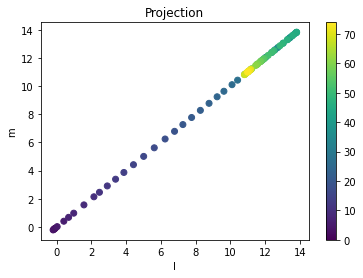

In [29]:
proj_m = []
proj_I = []
for i in range(len(x_t)):
    pm = proj(x_t[i], m)
    pj = proj(x_t[i], I)

    proj_m.append(pm)
    proj_I.append(pj)

plt.scatter(proj_m, proj_I, c=np.arange(len(x_t)), cmap='viridis')
plt.xlabel('I')
plt.ylabel('m')
plt.colorbar()
plt.title('Projection')

In [30]:
proj_I == proj_m

False

In [31]:

weights_data = np.array([I,n,m,w])

covMatrix = np.cov(weights_data)

In [32]:
covMatrix

array([[1.32318809, 1.31424586, 1.30992624, 1.18556354],
       [1.31424586, 1.30929356, 1.30195136, 1.17939837],
       [1.30992624, 1.30195136, 1.2994058 , 1.17453266],
       [1.18556354, 1.17939837, 1.17453266, 1.06482621]])

In [33]:
sigma_nm = covMatrix[2,1]
sigma_nI = covMatrix[0,1]
sigma_mw = covMatrix[2,3]

sigma_I = covMatrix[0,0]
sigma_n = covMatrix[1,1]
sigma_m = covMatrix[2,2]
sigma_w = covMatrix[3,3]

In [34]:
sigma_nm = 1.4
sigma_nI = 2.6
sigma_mw = 2.1

sigma_I = 1
sigma_n = 1
sigma_m = 1
sigma_w = 1

7. 

In [35]:
from scipy import integrate

def d_phi(delta):
    return 1- (np.tanh(delta))**2

def del_func(sigma_m, sigma_i, k, v):
    return np.sqrt((sigma_m**2) * (k**2) + (sigma_i**2) * (v**2))

def g_func(z, delta):
    return d_phi(delta*z)* np.exp(0.5*(-z**2)) / (2*np.pi)

def g_int(delta):
    return integrate.quadrature(g_func, -np.int, np.int, args=(delta))



SyntaxError: invalid syntax (<ipython-input-35-a291cf698658>, line 3)